In [11]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [2]:
#Let´s combine both datasets to work with them and then split them in train-test sets
df_train=pd.read_csv('/kaggle/input/titanic/train.csv')
df_test=pd.read_csv('/kaggle/input/titanic/test.csv')
df_full=pd.concat([df_train,df_test],ignore_index=True)

df_full.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB


In [4]:
#Let´s see which columns have null elements
df_full.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
dtype: int64

In [5]:
"""
Fare and class are related because is the amount of money they pay usually.
So let´s use the most common Fare value for the Pclass which belongs each
NaN Fare.

There are 2 missing values in "Embarked" column. We will fill them with
the most probable category.
"""
df_full["Embarked"].mode() #shows the most probable category

0    S
dtype: object

In [6]:
df_full["Embarked"].fillna("S", inplace=True)
#inplace to directly substitute the df and not doing a copy
df_full["Fare"].isnull().sum()
#only 1 fare is null, let´s see its category and add the median fare of that pclass

1

In [7]:
df_full[df_full["Fare"].isnull()]
#Male, not known if survived, NaN fare and cabin. Pclass 3

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1043,1044,NaN,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,NaN,S


In [8]:
print(df_full[df_full["Pclass"]==3].median())
#We see that the fare is 8.05, let´s put it into this lost fare
df_full["Fare"].fillna(df_full[df_full["Pclass"]==3]["Fare"].median(),inplace=True)
df_full.iloc[1043]

PassengerId    644.00
Survived         0.00
Pclass           3.00
Age             24.00
SibSp            0.00
Parch            0.00
Fare             8.05
dtype: float64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """Entry point for launching an IPython kernel.


PassengerId                  1044
Survived                      NaN
Pclass                          3
Name           Storey, Mr. Thomas
Sex                          male
Age                          60.5
SibSp                           0
Parch                           0
Ticket                       3701
Fare                         8.05
Cabin                         NaN
Embarked                        S
Name: 1043, dtype: object

In [9]:
"""
Let´s set the "Cabin" column to 1 for all rows where the "Cabin" is not null
and 0 otherwise. Maybe if user had one cabin the survival rate is greater.
Let´s overwrite in the column "Cabin" with a binary variable.
"""
print("Number of notnull cabins: ", df_full["Cabin"].notnull().sum())
print("Number of null cabins: ", df_full["Cabin"].isnull().sum())
df_full.loc[df_full["Cabin"].notnull(), "Cabin"]=1
df_full.loc[df_full["Cabin"].isnull(), "Cabin"]=0
print("Number of null cabins after modification: ", df_full["Cabin"].isnull().sum())
#Let´s plot the survival rate
print("Users without Cabin: ", (df_full["Cabin"]==0).sum())
print("Users with Cabin: ", (df_full["Cabin"]==1).sum())

Number of notnull cabins:  295
Number of null cabins:  1014
Number of null cabins after modification:  0
Users without Cabin:  1014
Users with Cabin:  295


       Survived
Cabin          
0      0.299854
1      0.666667


Text(0.5, 1.0, 'Survival Rate')

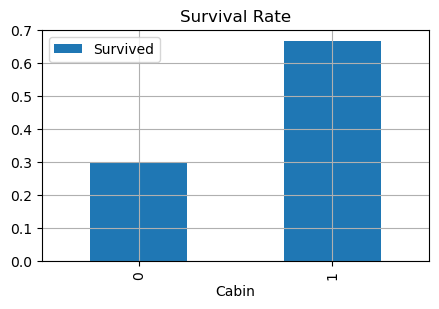

In [12]:
print(pd.pivot_table(df_full,index=['Cabin'],values=['Survived']))
pd.pivot_table(df_full,index=['Cabin'],values=['Survived']).plot.bar(figsize=(5,3))
plt.grid("True")
plt.title('Survival Rate')

In [13]:
"""
From here we can observe the results of the previous plots, the
0.666 of the survived is the average of the survived
with cabin and the 0.299 comes from the average of survived
without cabin it can be inferred that surviving is dependent of
whether having a cabin or not (more likely to survive if you had
a cabin)
"""
pd.crosstab(df_full["Cabin"], df_full["Survived"]).rename(index={0:"no cabin", 1:"cabin"}, columns={0.0: "not survived", 1.0: "survived"})


Survived,not survived,survived
Cabin,,
no cabin,481,206
cabin,68,136


In [14]:
#Remember the loss data
df_full.isnull().sum()
"""
Let´s analyze the name title name to infer the age.
Because you are more likely to survive if you are a kid than an adult
"""
#Let´s create a column:
df_full["Title"]=df_full["Name"].apply(lambda x: x.split(",")[1].split(".")[0].strip())
#.strip() is used to remove the leading and trailing whitespaces from the original string
#inclusing newline characters
df_full["Title"].value_counts()

Mr              757
Miss            260
Mrs             197
Master           61
Rev               8
Dr                8
Col               4
Mlle              2
Major             2
Ms                2
Lady              1
Sir               1
Mme               1
Don               1
Capt              1
the Countess      1
Jonkheer          1
Dona              1
Name: Title, dtype: int64

In [15]:
pd.crosstab(df_full.Title, df_full.Sex)

Sex,female,male
Title,,
Capt,0,1
Col,0,4
Don,0,1
Dona,1,0
Dr,1,7
Jonkheer,0,1
Lady,1,0
Major,0,2
Master,0,61


In [16]:
df_full[(df_full["Title"]=="Dr")&(df_full["Sex"]=="female")]
#There is one dr. which is female.

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
796,797,1.0,1,"Leader, Dr. Alice (Farnham)",female,49.0,0,0,17465,25.9292,1,S,Dr


In [17]:
#Less than 8 males (females) will be categorized as rareman (rarewoman)
nn={'Capt':'Rareman', 'Col':'Rareman','Don':'Rareman','Dona':'Rarewoman',
    'Dr':'Rareman','Jonkheer':'Rareman','Lady':'Rarewoman','Major':'Rareman',
    'Master':'Master','Miss':'Miss','Mlle':'Rarewoman','Mme':'Rarewoman',
    'Mr':'Mr','Mrs':'Mrs','Ms':'Rarewoman','Rev':'Mr','Sir':'Rareman',
    'the Countess':'Rarewoman'}
df_full.Title=df_full.Title.map(nn)
df_full.loc[df_full.PassengerId==797, "Title"]="Rarewoman"
df_full.Title.value_counts()

Mr           765
Miss         260
Mrs          197
Master        61
Rareman       17
Rarewoman      9
Name: Title, dtype: int64

In [18]:
#Let´s check what is master
df_full[df_full.Title=="Master"]["Age"].describe()
#We can observe that they are all kids

count    53.000000
mean      5.482642
std       4.161554
min       0.330000
25%       2.000000
50%       4.000000
75%       9.000000
max      14.500000
Name: Age, dtype: float64

In [19]:
#And in Miss they are all mixed in ages
df_full[df_full.Title=="Miss"]["Age"].describe()

count    210.000000
mean      21.774238
std       12.249077
min        0.170000
25%       15.000000
50%       22.000000
75%       30.000000
max       63.000000
Name: Age, dtype: float64

In [20]:
"""
Observing the dataframe we can inferre whether it was a girl
by checking the age.
"""
df_full[df_full.Title=="Miss"]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,0,S,Miss
10,11,1.0,3,"Sandstrom, Miss. Marguerite Rut",female,4.0,1,1,PP 9549,16.7000,1,S,Miss
11,12,1.0,1,"Bonnell, Miss. Elizabeth",female,58.0,0,0,113783,26.5500,1,S,Miss
14,15,0.0,3,"Vestrom, Miss. Hulda Amanda Adolfina",female,14.0,0,0,350406,7.8542,0,S,Miss
22,23,1.0,3,"McGowan, Miss. Anna ""Annie""",female,15.0,0,0,330923,8.0292,0,Q,Miss
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1293,1294,NaN,1,"Gibson, Miss. Dorothy Winifred",female,22.0,0,1,112378,59.4000,0,C,Miss
1299,1300,NaN,3,"Riordan, Miss. Johanna Hannah""""",female,NaN,0,0,334915,7.7208,0,Q,Miss
1300,1301,NaN,3,"Peacock, Miss. Treasteall",female,3.0,1,1,SOTON/O.Q. 3101315,13.7750,0,S,Miss
1301,1302,NaN,3,"Naughton, Miss. Hannah",female,NaN,0,0,365237,7.7500,0,Q,Miss


In [21]:
#Let´s fill the NaN cells in age by 999
df_full.Age.fillna("999", inplace=True)
df_full.Age=df_full.Age.astype(int)
#Now create a function to find the "girl" category
def girl(aa):
    if (aa.Age!=999)&(aa.Title=='Miss')&(aa.Age<=14):
        return "Girl"
    elif (aa.Age==999)&(aa.Title=="Miss")&(aa.Parch!=0):
        return "Girl"
    else:
        return aa.Title

df_full["Title"]=df_full.apply(girl,axis=1)
df_full["Title"].value_counts()

Mr           765
Miss         200
Mrs          197
Master        61
Girl          60
Rareman       17
Rarewoman      9
Name: Title, dtype: int64

In [22]:
#How many people are with not known age?
print(df_full[df_full["Age"]==999]["Age"].value_counts())
"""
To fill this lost information, let´s create a list with all titles,
then we will go through each title and for each title where the age
is  unknown we will introduce the mean age for that title.
"""
Tit=['Mr','Miss','Mrs','Master','Girl','Rareman','Rarewoman']
for i in Tit:
    df_full.loc[(df_full.Age==999)&(df_full.Title==i),'Age']=df_full.loc[df_full.Title==i,'Age'].median()
df_full.info()

999    263
Name: Age, dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1309 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1309 non-null   float64
 10  Cabin        1309 non-null   object 
 11  Embarked     1309 non-null   object 
 12  Title        1309 non-null   object 
dtypes: float64(3), int64(4), object(6)
memory usage: 133.1+ KB


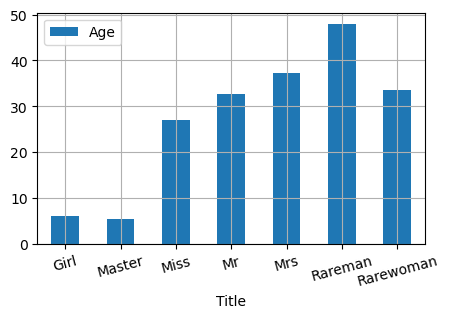

In [23]:
"""
Conclusion:

Now we know all variables with exception of one (survived) which is the
variable that we want to predict. If it survived (1) or not (0).

Let´s see the data after filling it.
"""

df_full.groupby(['Title'])[['Age','Title']].mean().plot(kind='bar',figsize=(5,3))
plt.grid("True")
plt.xticks(rotation=15)
plt.show()
#The age is perturbed because we have set age 999 to unknown ages

Survived  0.0  1.0
Sex               
female     81  233
male      468  109


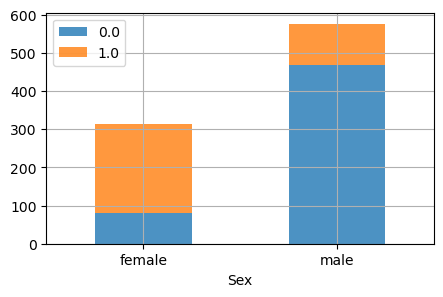

In [24]:
print(pd.crosstab(df_full.Sex,df_full.Survived))
pd.crosstab(df_full.Sex,df_full.Survived).plot.bar(stacked=True, alpha=0.8, figsize=(5,3))
plt.xticks(rotation=0)
plt.grid("True")
plt.legend()

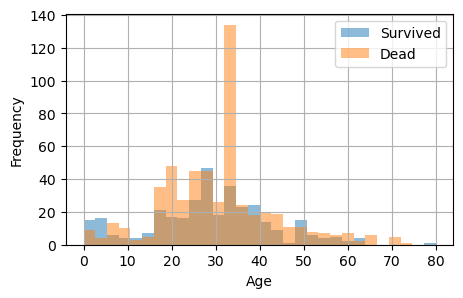

In [25]:
agehist=pd.concat([df_full[df_full.Survived==1]["Age"], df_full[df_full.Survived==0]["Age"]], axis=1)
agehist.columns=["Survived", "Dead"]
agehist.plot(kind="hist", bins=30, figsize=(5,3), alpha=0.5)
plt.xlabel("Age")
plt.grid("True")
#People most likely to die are from 20-40 with a peak around 32

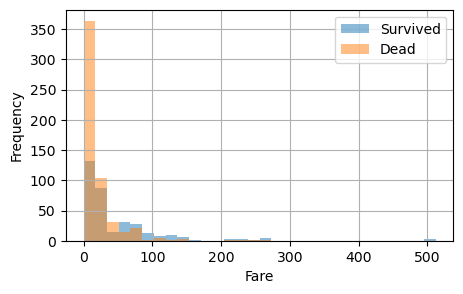

In [26]:
farehist=pd.concat([df_full[df_full.Survived==1]['Fare'],df_full[df_full.Survived==0]['Fare']],axis=1)
farehist.columns=["Survived", "Dead"]
farehist.plot(kind="hist", bins=30, figsize=(5,3), alpha=0.5)
plt.xlabel("Fare")
plt.grid("True")
#People with lowest fares tend to die (cheapest tickets)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  This is separate from the ipykernel package so we can avoid doing imports until


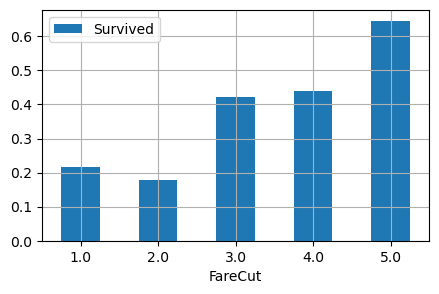

In [27]:
df_full.AgeCut=pd.cut(df_full.Age,5)
#cut the age in 5 categorical bins and call the column "AgeCut"
df_full.FareCut=pd.cut(df_full.Fare,5)
#same with fare
#print(df_full.AgeCut) #shows intervals, we want categorical values
#To do that, we do:
df_full.loc[df_full.Age<=16.136, "AgeCut"]=1
df_full.loc[(df_full.Age<=32.102)&(df_full.Age>=16.136), "AgeCut"]=2
df_full.loc[(df_full.Age<=48.068)&(df_full.Age>=32.102), "AgeCut"]=3
df_full.loc[(df_full.Age<=64.034)&(df_full.Age>=48.068), "AgeCut"]=4
df_full.loc[df_full.Age>64.034, "AgeCut"]=5

df_full.loc[df_full.Fare<=7.854, "FareCut"]=1
df_full.loc[(df_full.Fare<=10.5)&(df_full.Fare>=7.854), "FareCut"]=2
df_full.loc[(df_full.Fare<=21.558)&(df_full.Fare>=10.5), "FareCut"]=3
df_full.loc[(df_full.Fare<=41.579)&(df_full.Fare>=21.558), "FareCut"]=4
df_full.loc[df_full.Fare>41.579, "FareCut"]=5

df_full[["FareCut","Survived"]].groupby(["FareCut"]).mean().plot.bar(figsize=(5,3))
plt.grid()
plt.xticks(rotation=0)
plt.show()
#It can be observed that the ones with highest Fare are more likely to survive

In [28]:
df_full.corr()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,AgeCut,FareCut
PassengerId,1.000000,-0.005007,-0.038354,0.026166,-0.055224,0.008942,0.031029,0.018533,-0.003283
Survived,-0.005007,1.000000,-0.338481,-0.075346,-0.035322,0.081629,0.257307,-0.104350,0.320143
Pclass,-0.038354,-0.338481,1.000000,-0.364397,0.060832,0.018322,-0.558740,-0.326892,-0.732648
Age,0.026166,-0.075346,-0.364397,1.000000,-0.257942,-0.160293,0.155100,0.937382,0.135510
SibSp,-0.055224,-0.035322,0.060832,-0.257942,1.000000,0.373587,0.160388,-0.255275,0.345677
Parch,0.008942,0.081629,0.018322,-0.160293,0.373587,1.000000,0.221668,-0.157604,0.331123
Fare,0.031029,0.257307,-0.558740,0.155100,0.160388,0.221668,1.000000,0.132918,0.599520
AgeCut,0.018533,-0.104350,-0.326892,0.937382,-0.255275,-0.157604,0.132918,1.000000,0.092123
FareCut,-0.003283,0.320143,-0.732648,0.135510,0.345677,0.331123,0.599520,0.092123,1.000000


In [29]:
df_full[df_full.Survived.notnull()].pivot_table(index=['Title','Pclass'],values=['Survived']).sort_values('Survived',ascending=False)

Survived
Title     Pclass          
Rarewoman 2       1.000000
          1       1.000000
Master    1       1.000000
          2       1.000000
Girl      2       1.000000
Miss      1       0.977273
Mrs       1       0.976190
Miss      2       0.920000
Mrs       2       0.902439
Miss      3       0.560606
Mrs       3       0.500000
Girl      1       0.500000
Rareman   1       0.416667
Master    3       0.392857
Girl      3       0.388889
Mr        1       0.345794
          3       0.112853
          2       0.082474
Rareman   2       0.000000

In [30]:
df_full[df_full.Survived.notnull()].pivot_table(index=['Title','Parch'],values=['Survived']).sort_values('Survived',ascending=False)

Survived
Title     Parch          
Rarewoman 0      1.000000
Master    0      1.000000
Miss      1      0.875000
          2      0.857143
Mrs       0      0.855072
          1      0.812500
          2      0.769231
          3      0.750000
Miss      0      0.743363
Girl      1      0.650000
Master    1      0.608696
Girl      0      0.600000
Master    2      0.500000
Rareman   0      0.384615
Girl      2      0.363636
Mrs       5      0.250000
Mr        0      0.157447
          1      0.147059
          2      0.133333
          4      0.000000
          5      0.000000
Mrs       4      0.000000
          6      0.000000
Rareman   1      0.000000
Mr        3      0.000000

In [31]:
TPP=df_full[df_full.Survived.notnull()].pivot_table(index=['Title','Pclass','Parch'],values=['Survived']).sort_values('Survived',ascending=False)
TPP

Survived
Title     Pclass Parch          
Rarewoman 2      0      1.000000
Master    3      0      1.000000
Mrs       1      1      1.000000
          2      2      1.000000
                 3      1.000000
Miss      2      2      1.000000
                 1      1.000000
          1      2      1.000000
Mrs       1      0      1.000000
Miss      1      1      1.000000
Girl      2      1      1.000000
Master    2      2      1.000000
                 1      1.000000
          1      2      1.000000
Rarewoman 1      0      1.000000
Girl      2      2      1.000000
Miss      1      0      0.966667
Mrs       2      1      0.909091
Miss      2      0      0.904762
Mrs       2      0      0.869565
          3      2      0.666667
                 0      0.611111
Girl      3      0      0.600000
Miss      3      0      0.580645
Girl      3      1      0.533333
Mrs       1      2      0.500000
          3      3      0.500000
Girl      1      2      0.500000
Rareman   1      0      0.454545
Mrs       3      1      0.444444
Master    3      1      0.437500
Mr        1      2      0.400000
                 0      0.352273
Miss      3      2      0.333333
Mr        1      1      0.307692
Master    3      2      0.272727
Mrs       3      5      0.250000
Girl      3      2      0.187500
Mr        3      0      0.118644
          2      0      0.091954
          3      1      0.071429
          1      4      0.000000
Miss      3      1      0.000000
Mr        2      2      0.000000
          3      5      0.000000
Mrs       3      4      0.000000
Mr        3      4      0.000000
Mrs       3      6      0.000000
Mr        3      3      0.000000
Rareman   1      1      0.000000
          2      0      0.000000
Mr        3      2      0.000000
          2      1      0.000000

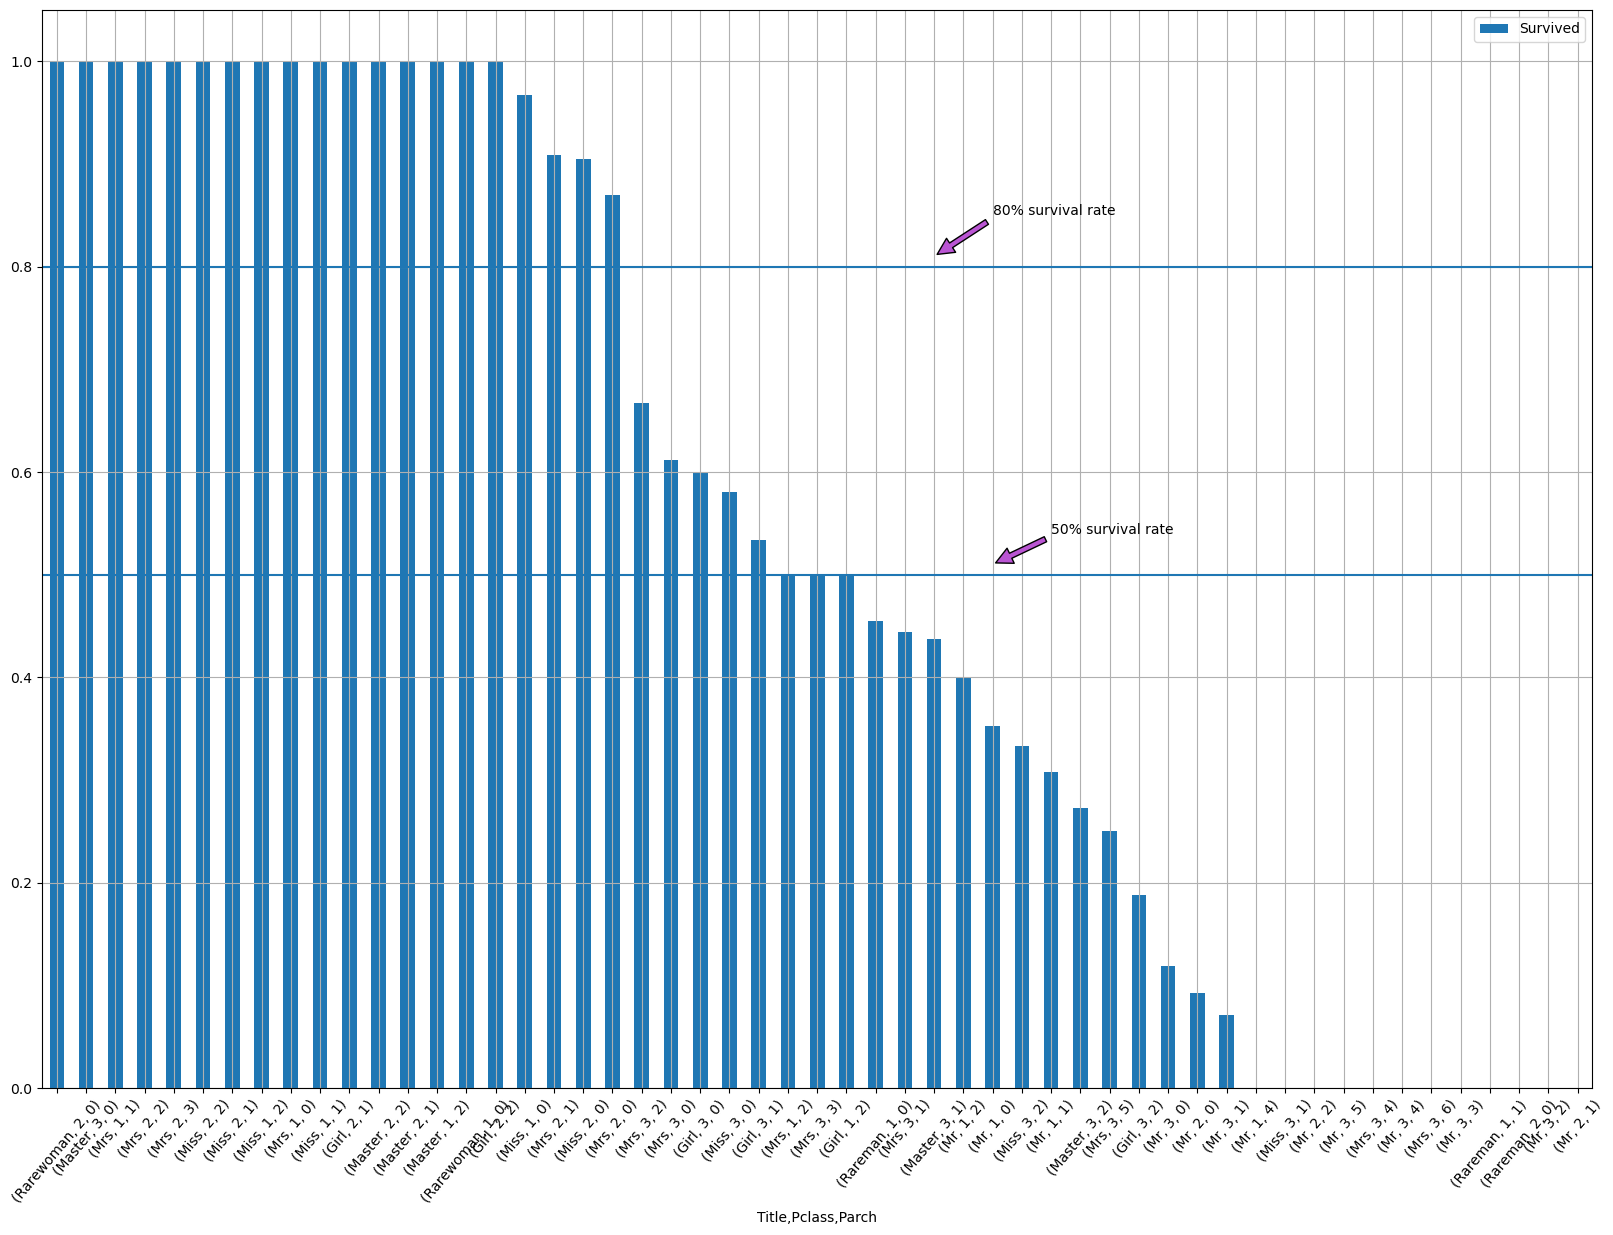

In [32]:
TPP.plot(kind="bar", figsize=(20,14))
plt.xticks(rotation=50)
plt.axhline(0.8)
plt.axhline(0.5)
plt.annotate("80% survival rate", xy=(30,0.81),xytext=(32,0.85),arrowprops=dict(facecolor='#BA55D3',shrink=0.05))
plt.annotate("50% survival rate", xy=(32,0.51),xytext=(34,0.54),arrowprops=dict(facecolor='#BA55D3',shrink=0.05))
plt.grid("True")

In [33]:
Tit=["Girl", "Master", "Mr", "Miss", "Mrs", "Rareman", "Rarewoman"]
for i in Tit:
    for j in range(1,4):
        for g in range(0,10):
            if df_full.loc[(df_full.Title==i)&(df_full.Pclass==j)&(df_full.Parch==g)&(df_full.Survived.notnull()), "Survived"].median()>=0.8:
                df_full.loc[(df_full.Title==i)&(df_full.Pclass==j)&(df_full.Parch==g), "TPP"]=1
            elif df_full.loc[(df_full.Title==i)&(df_full.Pclass==j)&(df_full.Parch==g)&(df_full.Survived.notnull()), "Survived"].median()>=0.5:
                df_full.loc[(df_full.Title==i)&(df_full.Pclass==j)&(df_full.Parch==g), "TPP"]=2
            elif df_full.loc[(df_full.Title==i)&(df_full.Pclass==j)&(df_full.Parch==g)&(df_full.Survived.notnull()), "Survived"].median()>=0:
                df_full.loc[(df_full.Title==i)&(df_full.Pclass==j)&(df_full.Parch==g), "TPP"]=3
            else:
                df_full.loc[(df_full.Title==i)&(df_full.Pclass==j)&(df_full.Parch==g), "TPP"]=4

#Let´s check the TPP=4

df_full[df_full.TPP==4]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,AgeCut,FareCut,TPP
915,916,NaN,1,"Ryerson, Mrs. Arthur Larned (Emily Maria Borie)",female,48.0,1,3,PC 17608,262.375,1,C,Mrs,3.0,5.0,4.0
960,961,NaN,1,"Fortune, Mrs. Mark (Mary McDougald)",female,60.0,1,4,19950,263.000,1,S,Mrs,4.0,5.0,4.0
979,980,NaN,3,"O'Donoghue, Ms. Bridget",female,33.0,0,0,364856,7.750,0,Q,Rarewoman,3.0,1.0,4.0
1011,1012,NaN,2,"Watt, Miss. Bertha J",female,12.0,0,0,C.A. 33595,15.750,0,S,Girl,1.0,3.0,4.0
1030,1031,NaN,3,"Goodwin, Mr. Charles Frederick",male,40.0,1,6,CA 2144,46.900,0,S,Mr,3.0,5.0,4.0
1033,1034,NaN,1,"Ryerson, Mr. Arthur Larned",male,61.0,1,3,PC 17608,262.375,1,C,Mr,4.0,5.0,4.0
1233,1234,NaN,3,"Sage, Mr. John George",male,34.0,1,9,CA. 2343,69.550,0,S,Mr,3.0,5.0,4.0
1256,1257,NaN,3,"Sage, Mrs. John (Annie Bullen)",female,39.0,1,9,CA. 2343,69.550,0,S,Mrs,3.0,5.0,4.0


In [34]:
#Let´s categorize that TPP:
df_full.loc[(df_full.TPP==4)&(df_full.Sex=="female")&(df_full.Pclass!=3), "TPP"]=1
df_full.loc[(df_full.TPP==4)&(df_full.Sex=="female")&(df_full.Pclass==3), "TPP"]=2
df_full.loc[(df_full.TPP==4)&(df_full.Sex=="male")&(df_full.Pclass!=3), "TPP"]=2
df_full.loc[(df_full.TPP==4)&(df_full.Sex=="male")&(df_full.Pclass==3), "TPP"]=3

df_full.TPP.value_counts()

3.0    870
1.0    428
2.0     11
Name: TPP, dtype: int64

In [35]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1309 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1309 non-null   float64
 10  Cabin        1309 non-null   object 
 11  Embarked     1309 non-null   object 
 12  Title        1309 non-null   object 
 13  AgeCut       1309 non-null   float64
 14  FareCut      1309 non-null   float64
 15  TPP          1309 non-null   float64
dtypes: float64(6), int64(4), object(6)
memory usage: 163.8+ KB


In [36]:
predictors=['Cabin','Embarked','Parch','Pclass','Sex','SibSp','Title','AgeCut','TPP','FareCut','Age','Fare']
df_full_dummies=pd.get_dummies(df_full[predictors])
df_full_dummies.head()

,Parch,Pclass,SibSp,AgeCut,TPP,FareCut,Age,Fare,Cabin_0,Cabin_1,...,Embarked_S,Sex_female,Sex_male,Title_Girl,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rareman,Title_Rarewoman
0,0,3,1,2.0,3.0,1.0,22.0,7.2500,1,0,...,1,0,1,0,0,0,1,0,0,0
1,0,1,1,3.0,1.0,5.0,38.0,71.2833,0,1,...,0,1,0,0,0,0,0,1,0,0
2,0,3,0,2.0,1.0,2.0,26.0,7.9250,1,0,...,1,1,0,0,0,1,0,0,0,0
3,0,1,1,3.0,1.0,5.0,35.0,53.1000,0,1,...,1,1,0,0,0,0,0,1,0,0
4,0,3,0,3.0,3.0,2.0,35.0,8.0500,1,0,...,1,0,1,0,0,0,1,0,0,0


**Modeling**

In [50]:
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

In [51]:
"""
Let´s try different combinations of models with its respective parameters
to compare performance.
"""

models=[KNeighborsClassifier(), LogisticRegression(), GaussianNB(), DecisionTreeClassifier(), RandomForestClassifier(), GradientBoostingClassifier(), SVC()]
X=df_full_dummies[:891] #grab all data from predictors until 891
y=df_full.Survived[:891] #grab all survived until 891 for training
test_X=df_full_dummies[891:] #grab the test data with its predictos

#Let´s scale the data
from sklearn.preprocessing import StandardScaler

scaler=StandardScaler()
X_scaled=scaler.fit(X).transform(X) #scale x training data
test_X_scaled=scaler.fit(test_X).transform(test_X)

"""
We run the models using cross-validation.
Cross validation is a technique used in ML to evaluate the performance of a model
on an independent dataset. It splits the available data into k folds or partitions,
using k-1 folds for the training and the k fold for the test. This process is repeated
k times. The results of the k iterations are averaged to get an estimation of the model´s
performance.
"""

names=["KNN", "LogReg", "NB", "DTC", "RFC", "GBC", "SVC"]
for name, model in zip(names,models):
    score=cross_val_score(model,X_scaled,y,cv=5)
    print("{}: {},{}\n".format(name, score.mean(),score))

KNN: 0.8047015253279769,[0.81564246 0.78089888 0.78089888 0.80337079 0.84269663]

LogReg: 0.8305128366078716,[0.84357542 0.81460674 0.81460674 0.82022472 0.85955056]

NB: 0.7957629778419434,[0.77094972 0.80898876 0.79775281 0.7752809  0.8258427 ]

DTC: 0.7945891657774151,[0.81564246 0.76966292 0.8258427  0.78089888 0.78089888]

RFC: 0.800207143305505,[0.81564246 0.75842697 0.83707865 0.76404494 0.8258427 ]

GBC: 0.8383842822170611,[0.83798883 0.80337079 0.85393258 0.82022472 0.87640449]

SVC: 0.8260247316552632,[0.83798883 0.80898876 0.8258427  0.79213483 0.86516854]



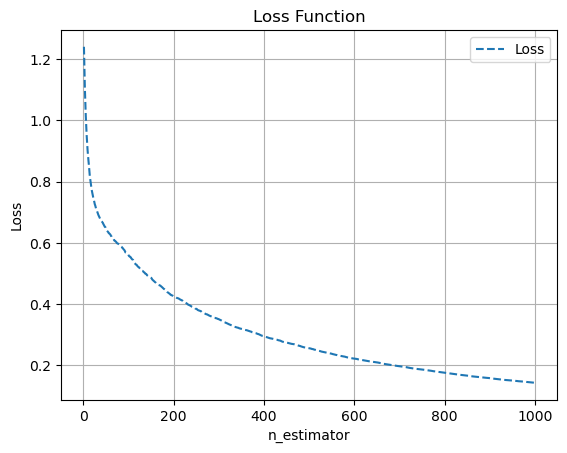

In [64]:
#Let´s use directly:
clf=GradientBoostingClassifier(n_estimators=1000, learning_rate=0.1, max_depth=3)
clf.fit(X_scaled,y)
loss_per_iteration=np.zeros((clf.n_estimators,), dtype=np.float64)
for i, y_pred in enumerate(clf.staged_decision_function(X_scaled)):
    loss_per_iteration[i]=clf.loss_(y,y_pred)

x_axis=np.linspace(1, len(loss_per_iteration), len(loss_per_iteration))
plt.plot(x_axis, loss_per_iteration, "--", label="Loss")
plt.xlabel('n_estimator')
plt.ylabel('Loss')
plt.title('Loss Function')
plt.grid("True")
plt.legend()
plt.show()

In [78]:
#Let´s predict whether the remaining ones will survive or not
y_predicted=clf.predict(test_X)
df_prediction=pd.DataFrame(y_predicted, columns=["Survived"])
#but we need to convert the total sum into a dataframe

/opt/conda/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


Survived
1.0         401
0.0          17
dtype: int64

Text(0.5, 1.0, 'Passengers predicted by GBDT')

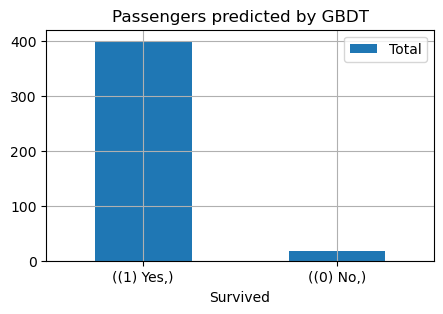

In [94]:
df_hist=pd.DataFrame(df_prediction.value_counts(), columns=["Total"])
df_hist.rename(index={0.0: "(0) No", 1.0: "(1) Yes"}, inplace=True)
#Let´s plot this renamed dataframe
df_hist.plot.bar(figsize=(5,3))
plt.xticks(rotation=0)
plt.grid()
plt.title("Passengers predicted by GBDT")

In [97]:
"""
We observe that the model with highest performance on average is GBC
We will use this model and LogReg to check the performance
"""

#GBC:

param_grid={"n_estimators":[30,50,70,90,110,150], "learning_rate":[0.05,0.1,0.4,0.9], "max_depth":[1,2,3,4,5]}
grid_search=GridSearchCV(GradientBoostingClassifier(), param_grid, cv=5)
grid_search.fit(X_scaled,y)
#After the fitting, we grab the best parameters and call it best_estimator
best_estimator=grid_search.best_estimator_
#Predict the test_X
#Let´s predict whether the remaining ones will survive or not

y_best_predicted=best_estimator.predict(test_X)
#We can´t compute the loss function during test because we don´t have y_test
df_best_prediction=pd.DataFrame(y_best_predicted, columns=["Survived"])
#but we need to convert the total sum into a dataframe
df_best_hist=pd.DataFrame(df_best_prediction.value_counts(), columns=["Total"])
df_best_hist.rename(index={0.0: "(0) No", 1.0: "(1) Yes"}, inplace=True)
df_best_hist

/opt/conda/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


,Total
Survived,
(1) Yes,400
(0) No,18


Text(0.5, 1.0, 'Passengers predicted by GBDT')

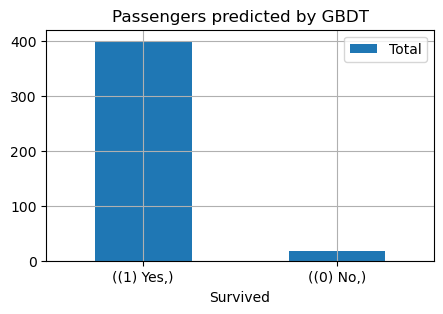

In [98]:
#Let´s plot this renamed dataframe
df_best_hist.plot.bar(figsize=(5,3))
plt.xticks(rotation=0)
plt.grid()
plt.title("Passengers predicted by GBDT")